# CRYPTO PREDICTOR

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch
import warnings
from lstm import LSTM

,Open,High,Low,Close,Volume
Date,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100


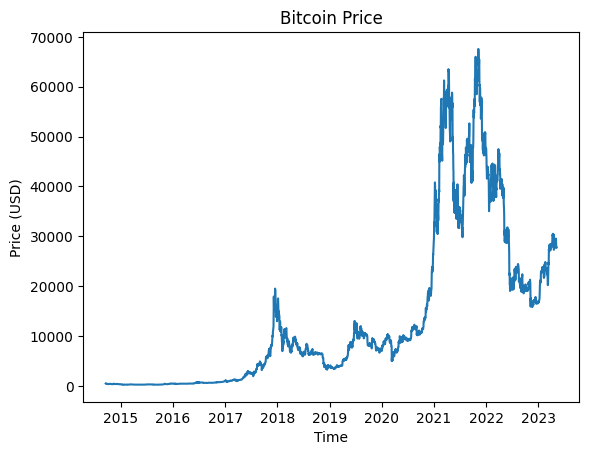

In [5]:
# read data and plot price in time
df = pd.read_csv('data/BTC-USD.csv', index_col='Date', parse_dates=True)
df.drop(columns='Adj Close', inplace=True)

display(df.head())

plt.plot(df['Close'])
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.title('Bitcoin Price')
plt.show()

In [8]:
X, y = df.drop(columns=['Close']), df.Close.values

# MinMaxScaler - scale data proportionally to the range of the data
min_max_scaler = MinMaxScaler()
y_standarized = min_max_scaler.fit_transform(y.reshape(-1, 1))

# StandardScaler - scale data to have a mean of 0 and a standard deviation of 1
standard_scaler = StandardScaler()
x_standarized = standard_scaler.fit_transform(X)

print(x_standarized)
print(y_standarized)

[[-0.80271459 -0.80287    -0.80422415 -0.84284687]
 [-0.80327593 -0.80355792 -0.80674862 -0.84216486]
 [-0.80531808 -0.80532272 -0.80858312 -0.84199029]
 ...
 [ 0.94191831  0.91146427  0.92021281  0.12745571]
 [ 0.8948254   0.86027634  0.92441619 -0.12623663]
 [ 0.89184148  0.8904432   0.90393611  0.12751872]]
[[0.00414359]
 [0.00365546]
 [0.00321557]
 ...
 [0.40832009]
 [0.40779333]
 [0.40885202]]


In [18]:
# create sequences from standarized data
def create_sequences(x_data, y_data, x_step, y_step):
    X, y = list(), list()
    for i in range(len(x_data)):
        x_end_idx = i + x_step
        y_end_ix = x_end_idx + y_step - 1
        if y_end_ix > len(x_data):
            break
        new_seq_x, new_seq_y = x_data[i:x_end_idx], y_data[x_end_idx-1:y_end_ix, -1]
        X.append(new_seq_x), y.append(new_seq_y)
    return np.array(X), np.array(y)

X_ss, y_mm = create_sequences(x_standarized, y_standarized, 100, 50)
print(X_ss.shape, y_mm.shape)

(3010, 100, 4) (3010, 50)


In [20]:
total_samples = len(X)
train_test_cutoff = round(0.90 * total_samples)

X_train = X_ss[:-150]
X_test = X_ss[-150:]

y_train = y_mm[:-150]
y_test = y_mm[-150:] 

print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape) 

Training Shape: (2860, 100, 4) (2860, 50)
Testing Shape: (150, 100, 4) (150, 50)


In [15]:
# convert to pytorch tensors
X_train_tensors = torch.Tensor(X_train)
X_test_tensors = torch.Tensor(X_test)

y_train_tensors = torch.Tensor(y_train)
y_test_tensors = torch.Tensor(y_test)

In [16]:
# reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,   
                                      (X_train_tensors.shape[0], 100, 
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,  
                                     (X_test_tensors.shape[0], 100, 
                                      X_test_tensors.shape[2])) 

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape: torch.Size([2860, 100, 4]) torch.Size([2860, 50])
Testing Shape: torch.Size([150, 100, 4]) torch.Size([150, 50])


In [22]:
X_check, y_check = create_sequences(X, y.reshape(-1, 1), 100, 50)
display(X.shape, y.shape)

(3158, 4)

(3158,)

In [20]:
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train,
                  X_test, y_test):
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train)
        optimiser.zero_grad()
        loss = loss_fn(outputs, y_train)
        loss.backward()
        optimiser.step()
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch % 100 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch,
                                                                      loss.item(),
                                                                      test_loss.item()))


In [23]:
warnings.filterwarnings('ignore')

n_epochs = 1000
learning_rate = 0.001

# number of features
input_size = 4

hidden_size = 2
num_layers = 1
num_classes = 50

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [21]:
training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors)

Epoch: 0, train loss: 0.11139, test loss: 0.10195
Epoch: 100, train loss: 0.05873, test loss: 0.01918
Epoch: 200, train loss: 0.00998, test loss: 0.02741
Epoch: 300, train loss: 0.00596, test loss: 0.01105
Epoch: 400, train loss: 0.00420, test loss: 0.00557
Epoch: 500, train loss: 0.00381, test loss: 0.00466
Epoch: 600, train loss: 0.00359, test loss: 0.00425
Epoch: 700, train loss: 0.00342, test loss: 0.00427
Epoch: 800, train loss: 0.00324, test loss: 0.00475
Epoch: 900, train loss: 0.00313, test loss: 0.00498


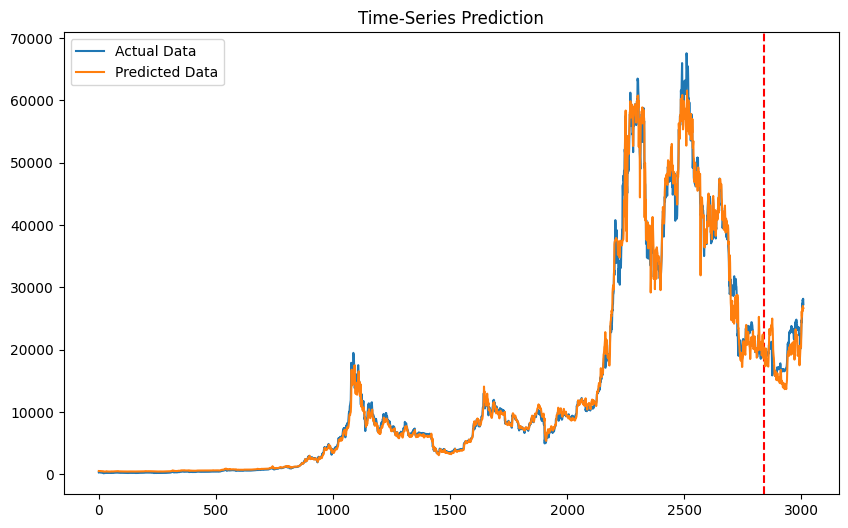

In [23]:
df_X_ss = standard_scaler.transform(df.drop(columns=['Close']))
df_y_mm = min_max_scaler.transform(df.Close.values.reshape(-1, 1))

df_X_ss, df_y_mm = create_sequences(df_X_ss, df_y_mm, 100, 50)

df_X_ss = torch.Tensor(df_X_ss)
df_y_mm = torch.Tensor(df_y_mm)

df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 100, df_X_ss.shape[2]))

train_predict = lstm(df_X_ss)
data_predict = train_predict.data.numpy()
dataY_plot = df_y_mm.data.numpy()

data_predict = min_max_scaler.inverse_transform(data_predict)
dataY_plot = min_max_scaler.inverse_transform(dataY_plot)
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
plt.figure(figsize=(10,6))
plt.axvline(x=train_test_cutoff, c='r', linestyle='--')

plt.plot(true, label='Actual Data')
plt.plot(preds, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

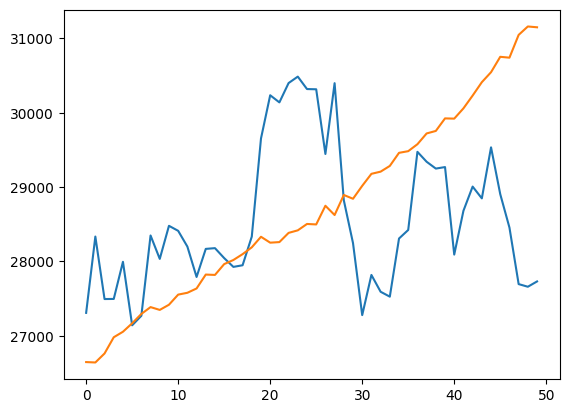

In [24]:
test_predict = lstm(X_test_tensors_final[-1].unsqueeze(0))
test_predict = test_predict.detach().numpy()
test_predict = min_max_scaler.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

test_target = y_test_tensors[-1].detach().numpy()
test_target = min_max_scaler.inverse_transform(test_target.reshape(1, -1))
test_target = test_target[0].tolist()

plt.plot(test_target, label="Actual Data")
plt.plot(test_predict, label="LSTM Predictions")
plt.show()

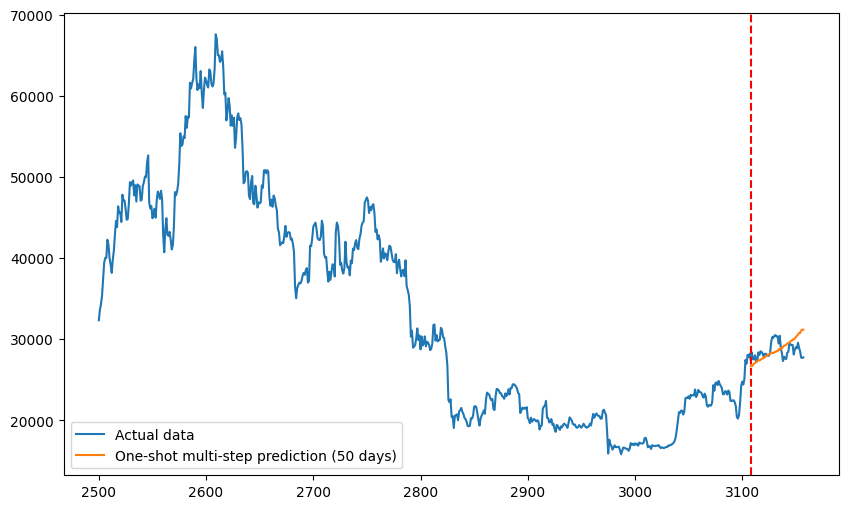

In [25]:
plt.figure(figsize=(10,6))
a = [x for x in range(2500, len(y))]
plt.plot(a, y[2500:], label='Actual data');
c = [x for x in range(len(y)-50, len(y))]
plt.plot(c, test_predict, label='One-shot multi-step prediction (50 days)')
plt.axvline(x=len(y)-50, c='r', linestyle='--')
plt.legend()
plt.show()